In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pickle
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression


In [2]:
# Step 1: Load the graph from the edge list
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)

# Step 2: Get the adjacency matrix
adj = nx.adjacency_matrix(G)

# Print the adjacency matrix (dense)
print(adj)


  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  :	:
  (4031, 4024)	1
  (4031, 4027)	1
  (4032, 1827)	1
  (4032, 4028)	1
  (4033, 1827)	1
  (4033, 3989)	1
  (4033, 4002)	1
  (4034, 1827)	1
  (4034, 4024)	1
  (4035, 1827)	1
  (4036, 1827)	1
  (4036, 4001)	1
  (4037, 1827)	1
  (4037, 3985)	1
  (4037, 4015)	1
  (4037, 4021)	1
  (4038, 1827)	1
  (4038, 1828)	1
  (4038, 1830)	1
  (4038, 4006)	1
  (4038, 4014)	1
  (4038, 4015)	1
  (4038, 4021)	1
  (4038, 4024)	1
  (4038, 4028)	1


In [3]:
print(G)

Graph with 4039 nodes and 88234 edges


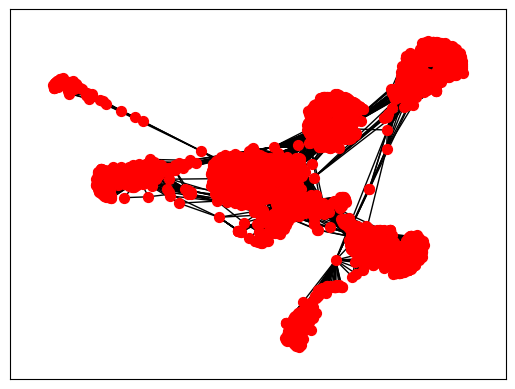

In [4]:
nx.draw_networkx(G, with_labels=False, node_size=50, node_color='r')
plt.show()

In [5]:
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_array(adj)

    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print("creating false train edges...")

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false


In [10]:
# Convert sparse matrix to tuple
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [9]:
# Get normalized adjacency matrix: A_norm
def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


In [12]:
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.adjacency_matrix(G)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)


In [14]:
g_train = nx.from_scipy_sparse_array(adj_train) # new graph object with only non-hidden edges

In [15]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 4039
Total edges: 88234
Training edges (positive): 52941
Training edges (negative): 52941
Validation edges (positive): 8823
Validation edges (negative): 8823
Test edges (positive): 26470
Test edges (negative): 26470


In [20]:
import numpy as np
import networkx as nx
import random


class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length, verbose=True):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		if verbose == True:
			print('Walk iteration:')
		for walk_iter in range(num_walks):
			if verbose == True:
				print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return


def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=int)


	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [21]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [26]:
# Preprocessing, generate walks
g_n2v = Graph(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [list(map(str, walk)) for walk in walks]

# Train skip-gram model
model = Word2Vec(walks, vector_size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, epochs=ITER)

# Store embeddings mapping
emb_mappings = model.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [27]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [31]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [32]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [34]:
edge_classifier = LogisticRegression(random_state=42)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=42)

In [35]:
# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

In [36]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [37]:
print('node2vec Validation ROC score: ', str(val_roc))
print('node2vec Validation AP score: ', str(val_ap))
print('node2vec Test ROC score: ', str(test_roc))
print('node2vec Test AP score: ', str(test_ap))

node2vec Validation ROC score:  0.9890669997682199
node2vec Validation AP score:  0.9835551669213505
node2vec Test ROC score:  0.9900517026139178
node2vec Test AP score:  0.9859515685600491
